## bash

In [8]:
!bash scripts/tune_all.sh

===== SWEEP for S =====
>>> S LR=1e-3 DO=0.0 EL=2 DM=256 PL=16
True
Args in experiment:
Basic Config
  Task Name:          long_term_forecast  Is Training:        1                   
  Model ID:           EPF_168_24_S        Model:              TimeXer             

Data Loader
  Data:               custom              Root Path:          ./data              
  Data Path:          causal_data.csv     Features:           S                   
  Target:             electricity_price   Freq:               h                   
  Checkpoints:        ./checkpoints/      
  Predictor(s):       __NONE__            

Forecasting Task
  Seq Len:            168                 Label Len:          48                  
  Pred Len:           24                  Seasonal Patterns:  Monthly             
  Inverse:            0                   

Model Parameters
  Top k:              5                   Num Kernels:        6                   
  Enc In:             1                   Dec In:        

## dfs

In [3]:
import re, pandas as pd
from pathlib import Path

# ---------- helper -------------------------------------------------
ESC        = re.compile(r'\x1b\[[0-9;]*m')                           # strip ANSI colour codes
start_re   = re.compile(r'start training.*?_pl(\d+)_dm(\d+).*?_el(\d+)_')
lr_re      = re.compile(r'Learning Rate:\s*([0-9.eE+-]+)')
do_re      = re.compile(r'Dropout:\s*([0-9.eE+-]+)')
msemae_re  = re.compile(r'mse:\s*([0-9.eE+-]+).*?mae:\s*([0-9.eE+-]+)', re.I)

def parse_log(path: Path) -> pd.DataFrame:
    rows, cur = [], {}
    with path.open() as fh:
        for raw in fh:
            line = ESC.sub('', raw).strip()

            if m := start_re.search(line):                     # PL, DM, EL
                cur.update({'PL': int(m.group(1)),
                            'DM': int(m.group(2)),
                            'EL': int(m.group(3))})
                continue

            if m := lr_re.search(line):                        # LR
                cur['LR'] = float(m.group(1));  continue
            if m := do_re.search(line):                        # DO
                cur['DO'] = float(m.group(1));  continue

            if m := msemae_re.search(line):                    # mse, mae → commit row
                if {'LR','DO','EL','DM','PL'}.issubset(cur):
                    rows.append({**cur,
                                'mse': float(m.group(1)),
                                'mae': float(m.group(2))})
                cur = {}                                       # reset

    df = pd.DataFrame(rows, columns=['LR','DO','EL','DM','PL','mse','mae'])
    return df

# ---------- parse the three logs ----------------------------------
logs = {
    'df_S'       : Path('tuning_S.log'),
    'df_MS_Pen'  : Path('tuning_MS_Pen.log'),
    'df_MS_Raw'  : Path('tuning_MS_Raw.log'),
}

results = {}
for name, file in logs.items():
    if not file.exists():
        raise FileNotFoundError(f'Expected log {file} not found')
    results[name] = parse_log(file)

# results['df_S'], results['df_MS_Pen'], results['df_MS_Raw'] are the three DataFrames
for k, df in results.items():
    print(f'\n{k}  |  rows: {len(df)}')
    display(df.head())


df_S  |  rows: 162


LR   DO  EL   DM  PL       mse       mae
0  0.001  0.0   2  256  24  0.146952  0.238696
1  0.001  0.0   2  256  24  0.114301  0.204480
2  0.001  0.0   2  256  24  0.142268  0.238371
3  0.001  0.0   2  512  24  0.139084  0.237838
4  0.001  0.0   2  512  24  0.122917  0.217388


df_MS_Pen  |  rows: 162


LR   DO  EL   DM  PL       mse       mae
0  0.001  0.0   2  256  24  0.139887  0.234684
1  0.001  0.0   2  256  24  0.118209  0.207252
2  0.001  0.0   2  256  24  0.138288  0.242591
3  0.001  0.0   2  512  24  0.170695  0.265607
4  0.001  0.0   2  512  24  0.141733  0.238636


df_MS_Raw  |  rows: 162


LR   DO  EL   DM  PL       mse       mae
0  0.001  0.0   2  256  24  0.163181  0.260688
1  0.001  0.0   2  256  24  0.116421  0.209235
2  0.001  0.0   2  256  24  0.140597  0.241085
3  0.001  0.0   2  512  24  0.168547  0.270375
4  0.001  0.0   2  512  24  0.135435  0.231636

In [5]:
best_S = results['df_S'].sort_values('mse').head(1)
best_pen = results['df_MS_Pen'].sort_values('mse').head(1)
best_raw = results['df_MS_Raw'].sort_values('mse').head(1)

In [6]:
print(best_S)
print(best_pen)
print(best_raw)

         LR   DO  EL   DM  PL       mse       mae
133  0.0001  0.1   3  256  24  0.104929  0.195106
       LR   DO  EL   DM  PL       mse       mae
37  0.001  0.2   2  256  24  0.112225  0.202119
        LR   DO  EL   DM  PL       mse       mae
91  0.0005  0.2   2  256  24  0.104427  0.196775


## plots

In [1]:
import re
import pandas as pd
from pathlib import Path

# ---------- regex helpers -----------------------------
ESC = re.compile(r'\x1b\[[0-9;]*m')  # strip ANSI colour codes

setup_re = re.compile(r'LR=([0-9.eE+-]+)\s+DO=([0-9.eE+-]+)\s+EL=(\d+)\s+DM=(\d+)\s+PL=(\d+)', re.I)
msemae_re = re.compile(r'mse:\s*([0-9.eE+-]+).*?mae:\s*([0-9.eE+-]+)', re.I)

# ---------- core parser -----------------------------
def parse_log(path: Path) -> pd.DataFrame:
    rows, cur = [], {}
    with path.open() as fh:
        for raw in fh:
            line = ESC.sub('', raw).strip()

            if m := setup_re.search(line):
                cur.update({
                    'LR': float(m.group(1)),
                    'DO': float(m.group(2)),
                    'EL': int(m.group(3)),
                    'DM': int(m.group(4)),
                    'PL': int(m.group(5)),
                })
                continue

            if m := msemae_re.search(line):
                if {'LR', 'DO', 'EL', 'DM', 'PL'}.issubset(cur):
                    rows.append({
                        **cur,
                        'mse': float(m.group(1)),
                        'mae': float(m.group(2))
                    })
                cur = {}

    cols = ['LR', 'DO', 'EL', 'DM', 'PL', 'mse', 'mae']
    return pd.DataFrame(rows)[cols]

# ---------- run parser on MS_Raw only -----------------------------
logfile = Path('tuning_MS_Raw.log')
if not logfile.exists():
    raise FileNotFoundError(f'Expected log {logfile} not found')

df_MS_Raw = parse_log(logfile)

print(f'rows parsed: {len(df_MS_Raw)}')
print(df_MS_Raw.head())

rows parsed: 162
      LR   DO  EL   DM  PL       mse       mae
0  0.001  0.0   2  256  16  0.163181  0.260688
1  0.001  0.0   2  256  24  0.116421  0.209235
2  0.001  0.0   2  256  48  0.140597  0.241085
3  0.001  0.0   2  512  16  0.168547  0.270375
4  0.001  0.0   2  512  24  0.135435  0.231636


In [2]:
df=df_MS_Raw

In [3]:
df.head(50)

LR   DO  EL   DM  PL       mse       mae
0   0.001  0.0   2  256  16  0.163181  0.260688
1   0.001  0.0   2  256  24  0.116421  0.209235
2   0.001  0.0   2  256  48  0.140597  0.241085
3   0.001  0.0   2  512  16  0.168547  0.270375
4   0.001  0.0   2  512  24  0.135435  0.231636
5   0.001  0.0   2  512  48  0.154389  0.248131
6   0.001  0.0   3  256  16  0.159279  0.263933
7   0.001  0.0   3  256  24  0.154941  0.251267
8   0.001  0.0   3  256  48  0.154593  0.252041
9   0.001  0.0   3  512  16  0.160060  0.258478
10  0.001  0.0   3  512  24  0.154063  0.252839
11  0.001  0.0   3  512  48  0.175663  0.269662
12  0.001  0.0   4  256  16  0.162558  0.257950
13  0.001  0.0   4  256  24  0.157289  0.254738
14  0.001  0.0   4  256  48  0.154111  0.252454
15  0.001  0.0   4  512  16  0.169305  0.265010
16  0.001  0.0   4  512  24  0.158426  0.258602
17  0.001  0.0   4  512  48  0.164423  0.262524
18  0.001  0.1   2  256  16  0.131002  0.224135
19  0.001  0.1   2  256  24  0.110150  0.202134
20  0.001  0.1   2  256  48  0.149871  0.246455
21  0.001  0.1   2  512  16  0.163577  0.258739
22  0.001  0.1   2  512  24  0.167818  0.261163
23  0.001  0.1   2  512  48  0.167823  0.265283
24  0.001  0.1   3  256  16  0.137509  0.230977
25  0.001  0.1   3  256  24  0.140623  0.230752
26  0.001  0.1   3  256  48  0.153724  0.251459
27  0.001  0.1   3  512  16  0.156274  0.254190
28  0.001  0.1   3  512  24  0.164715  0.259517
29  0.001  0.1   3  512  48  0.162313  0.257030
30  0.001  0.1   4  256  16  0.161433  0.261800
31  0.001  0.1   4  256  24  0.149250  0.244295
32  0.001  0.1   4  256  48  0.143351  0.240250
33  0.001  0.1   4  512  16  0.156617  0.254265
34  0.001  0.1   4  512  24  0.150909  0.248287
35  0.001  0.1   4  512  48  0.154820  0.252011
36  0.001  0.2   2  256  16  0.136822  0.230131
37  0.001  0.2   2  256  24  0.112203  0.204322
38  0.001  0.2   2  256  48  0.136472  0.232906
39  0.001  0.2   2  512  16  0.167284  0.260146
40  0.001  0.2   2  512  24  0.176130  0.267167
41  0.001  0.2   2  512  48  0.172032  0.270293
42  0.001  0.2   3  256  16  0.147643  0.244725
43  0.001  0.2   3  256  24  0.149746  0.242802
44  0.001  0.2   3  256  48  0.155627  0.250330
45  0.001  0.2   3  512  16  0.158538  0.253393
46  0.001  0.2   3  512  24  0.159889  0.255709
47  0.001  0.2   3  512  48  0.165778  0.261321
48  0.001  0.2   4  256  16  0.152691  0.245261
49  0.001  0.2   4  256  24  0.156141  0.253127

In [6]:
df.to_csv('hyperparameters.csv', index=False)

In [2]:
import pandas as pd
df = pd.read_csv('hyperparameters.csv')

In [3]:
df_ordered = df.sort_values(by='mse', ascending=True).reset_index(drop=True)
df_ordered

LR   DO  EL   DM  PL       mse       mae
0    0.0005  0.2   2  256  24  0.104427  0.196775
1    0.0001  0.2   4  512  24  0.105916  0.195343
2    0.0001  0.2   4  256  24  0.106452  0.195598
3    0.0001  0.2   2  256  24  0.107361  0.196184
4    0.0001  0.2   3  256  24  0.107814  0.196356
..      ...  ...  ..  ...  ..       ...       ...
157  0.0010  0.0   4  512  16  0.169305  0.265010
158  0.0010  0.2   2  512  48  0.172032  0.270293
159  0.0010  0.0   3  512  48  0.175663  0.269662
160  0.0005  0.0   4  512  48  0.175911  0.274322
161  0.0010  0.2   2  512  24  0.176130  0.267167

[162 rows x 7 columns]

In [5]:
df_ordered_2 = df.sort_values(by='mae', ascending=True).reset_index(drop=True)
df_ordered_2

LR   DO  EL   DM  PL       mse       mae
0    0.0001  0.2   4  512  24  0.105916  0.195343
1    0.0001  0.2   4  256  24  0.106452  0.195598
2    0.0001  0.2   2  256  24  0.107361  0.196184
3    0.0001  0.2   3  256  24  0.107814  0.196356
4    0.0005  0.2   2  256  24  0.104427  0.196775
..      ...  ...  ..  ...  ..       ...       ...
157  0.0010  0.2   2  512  24  0.176130  0.267167
158  0.0010  0.0   3  512  48  0.175663  0.269662
159  0.0010  0.2   2  512  48  0.172032  0.270293
160  0.0010  0.0   2  512  16  0.168547  0.270375
161  0.0005  0.0   4  512  48  0.175911  0.274322

[162 rows x 7 columns]

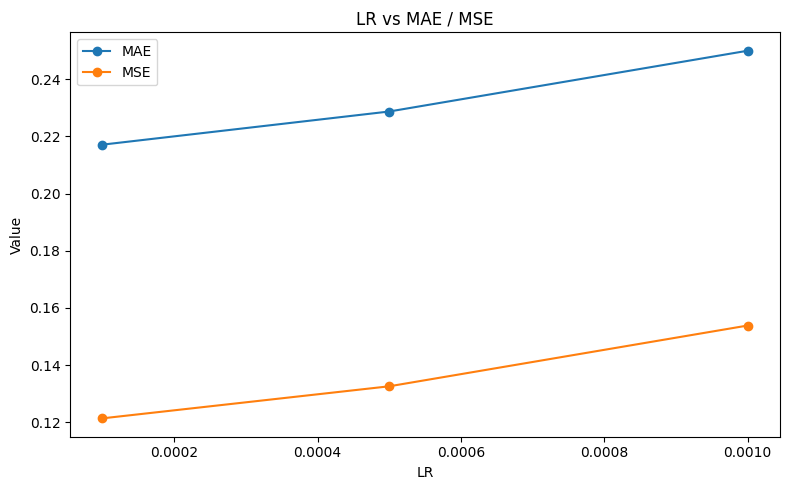

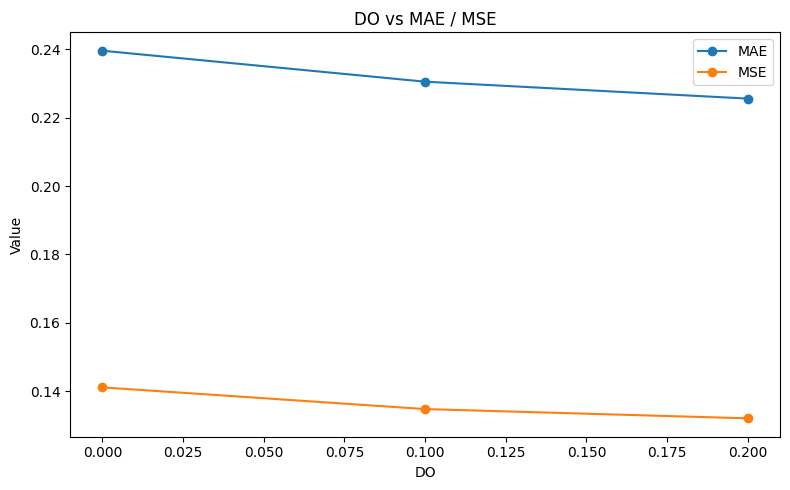

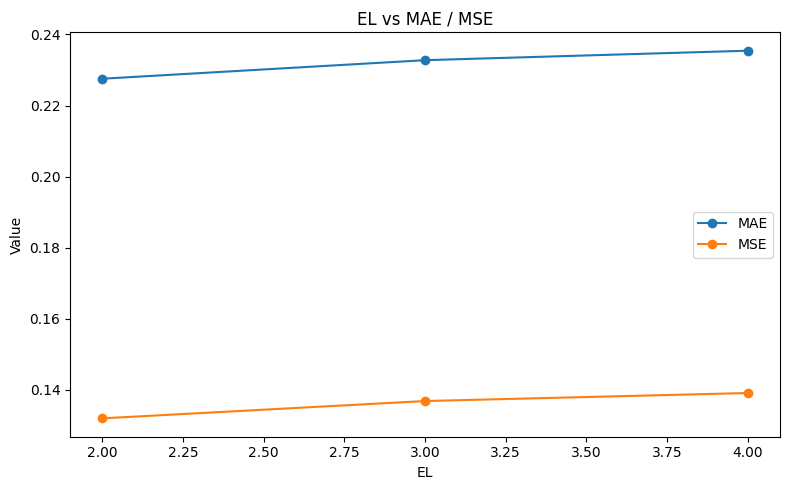

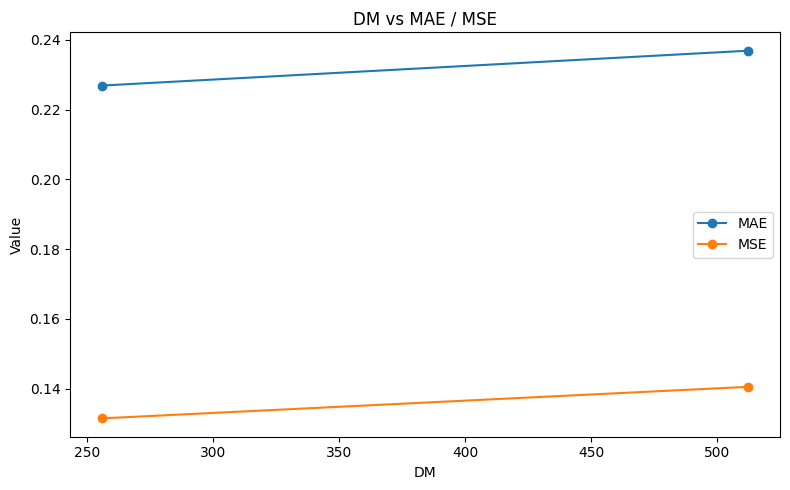

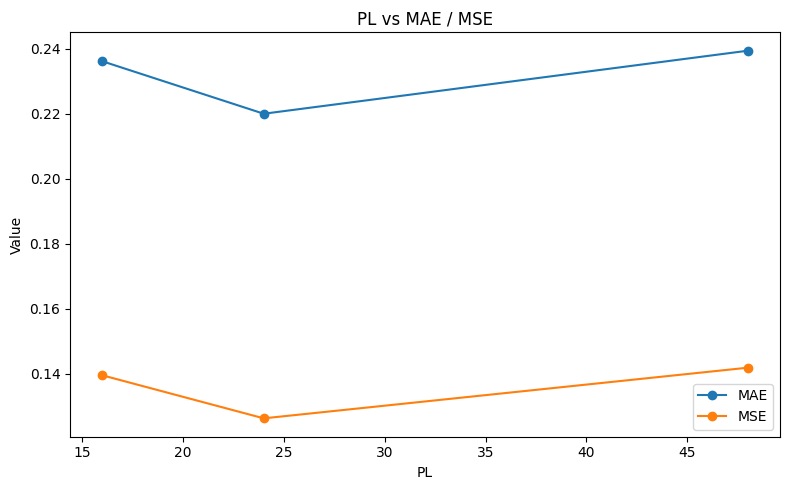

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'  # or 'serif' if not available

# Turn off interactive mode if using Jupyter or notebooks
plt.ioff()

# Set figure style
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

for param in hyperparams:
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()

    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped['mae'], marker='o', label='MAE')
    plt.plot(grouped.index, grouped['mse'], marker='o', label='MSE')
    plt.xlabel(param)
    plt.ylabel('Value')
    plt.title(f'{param} vs MAE / MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()

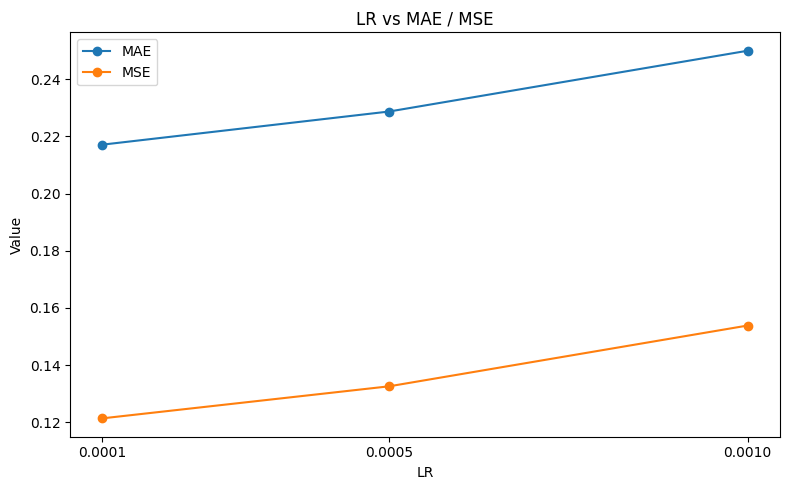

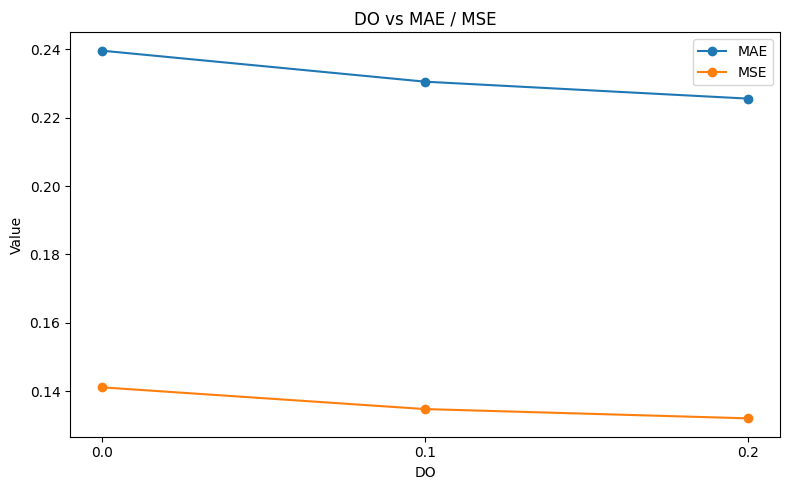

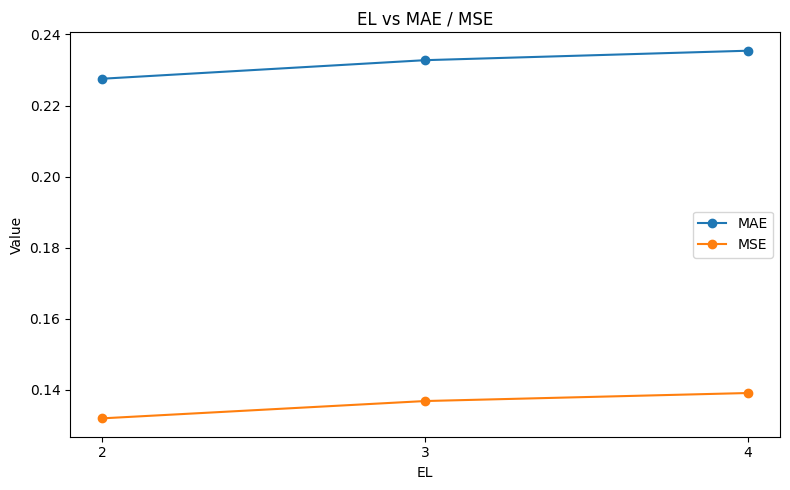

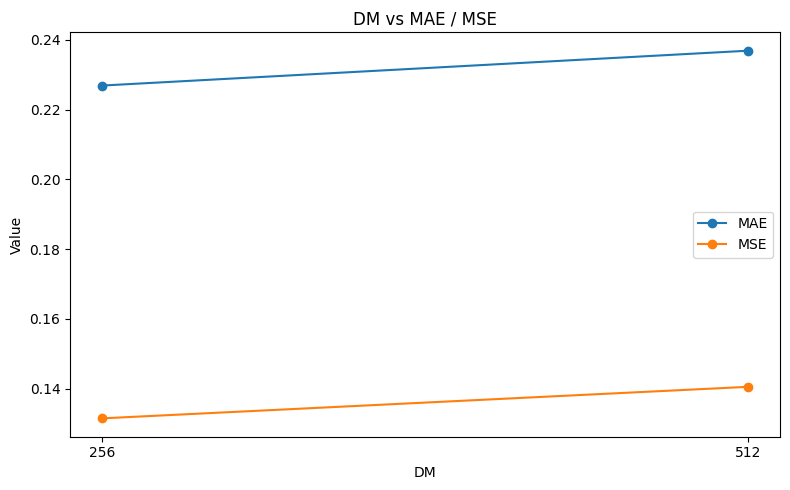

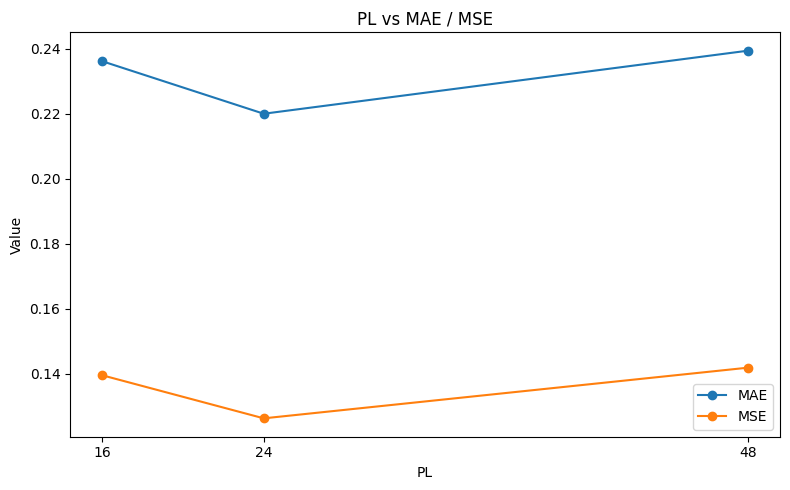

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'  # or 'serif' if not available
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

# Define the test value lists
param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

for param in hyperparams:
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()

    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped['mae'], marker='o', label='MAE')
    plt.plot(grouped.index, grouped['mse'], marker='o', label='MSE')
    plt.xlabel(param)
    plt.ylabel('Value')
    plt.title(f'{param} vs MAE / MSE')
    plt.legend()

    # Set the x-ticks to include all tested values
    xticks = param_values[param]
    plt.xticks(xticks)

    plt.tight_layout()
    plt.show()

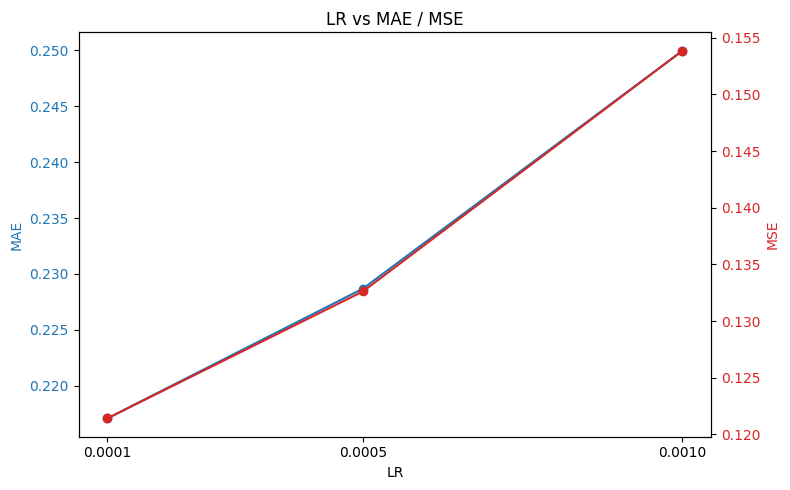

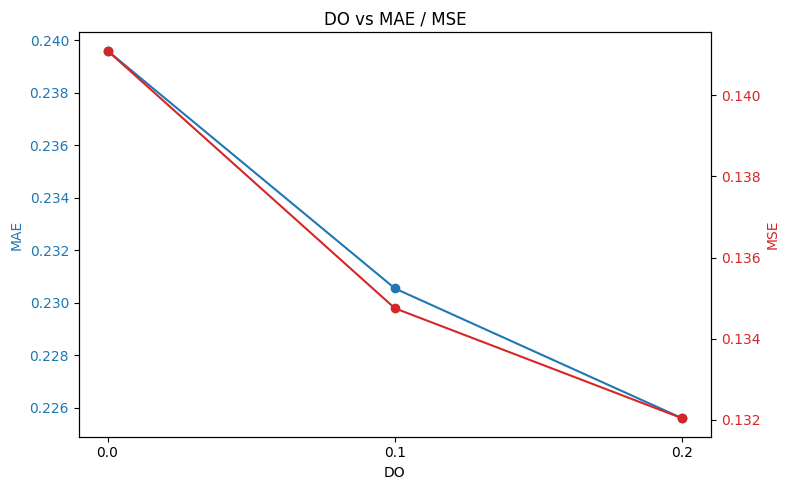

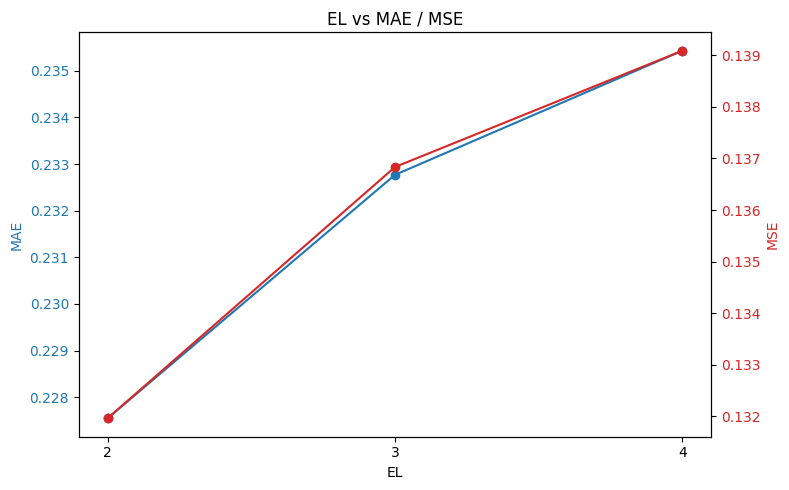

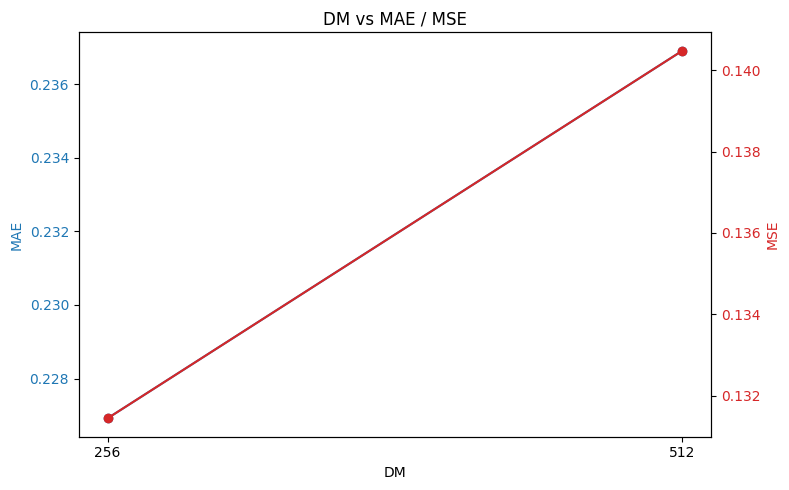

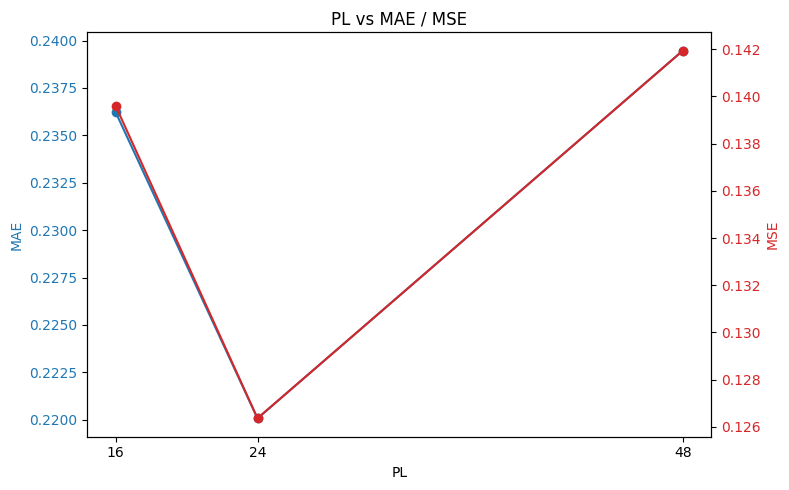

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

for param in hyperparams:
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()

    fig, ax1 = plt.subplots(figsize=(8, 5))

    color1 = 'tab:blue'
    ax1.set_xlabel(param)
    ax1.set_ylabel('MAE', color=color1)
    ax1.plot(grouped.index, grouped['mae'], marker='o', color=color1, label='MAE')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()  # Create a second y-axis
    color2 = 'tab:red'
    ax2.set_ylabel('MSE', color=color2)
    ax2.plot(grouped.index, grouped['mse'], marker='o', color=color2, label='MSE')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.xticks(param_values[param])  # Ensure x-axis has all tested values

    plt.title(f'{param} vs MAE / MSE')
    fig.tight_layout()
    plt.show()

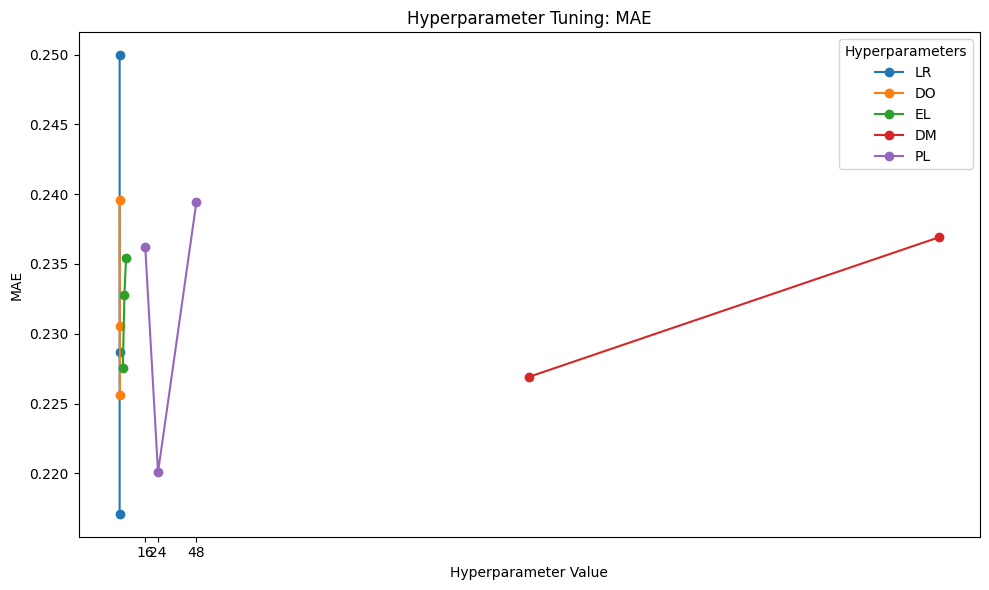

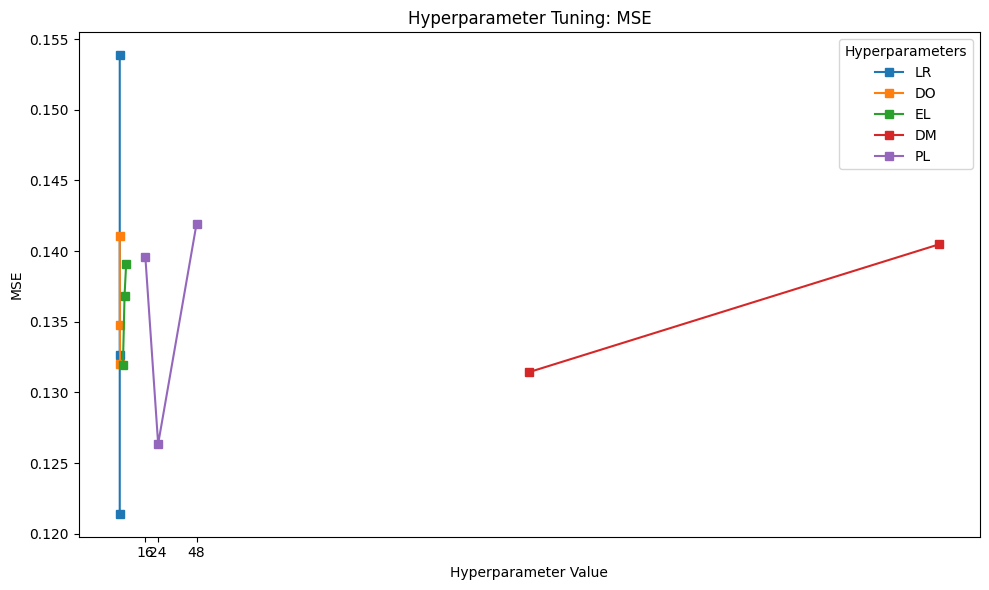

In [7]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

# Plot all MAE
plt.figure(figsize=(10, 6))
for param in hyperparams:
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    plt.plot(grouped.index, grouped['mae'], marker='o', label=param)
    plt.xticks(param_values[param])
plt.xlabel('Hyperparameter Value')
plt.ylabel('MAE')
plt.title('Hyperparameter Tuning: MAE')
plt.legend(title='Hyperparameters')
plt.tight_layout()
plt.show()

# Plot all MSE
plt.figure(figsize=(10, 6))
for param in hyperparams:
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    plt.plot(grouped.index, grouped['mse'], marker='s', label=param)
    plt.xticks(param_values[param])
plt.xlabel('Hyperparameter Value')
plt.ylabel('MSE')
plt.title('Hyperparameter Tuning: MSE')
plt.legend(title='Hyperparameters')
plt.tight_layout()
plt.show()

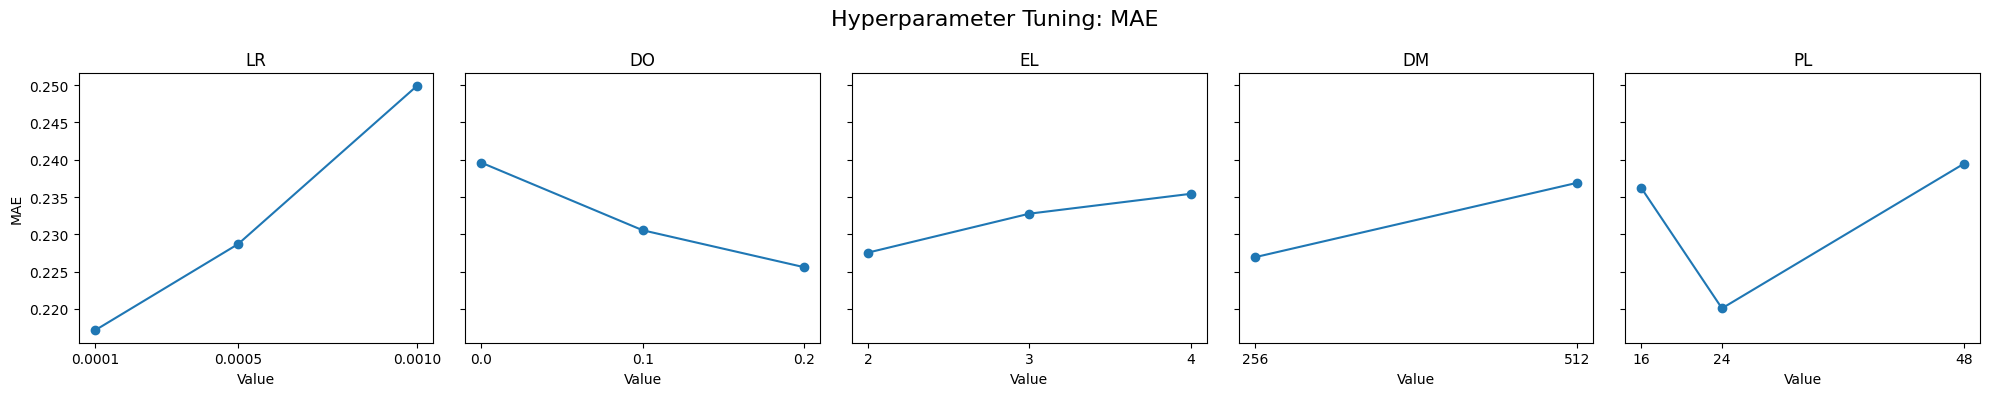

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for ax, param in zip(axes, hyperparams):
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    ax.plot(grouped.index, grouped['mae'], marker='o')
    ax.set_title(param)
    ax.set_xticks(param_values[param])
    ax.set_xlabel('Value')

axes[0].set_ylabel('MAE')
fig.suptitle('Hyperparameter Tuning: MAE', fontsize=16)
plt.tight_layout()
plt.show()

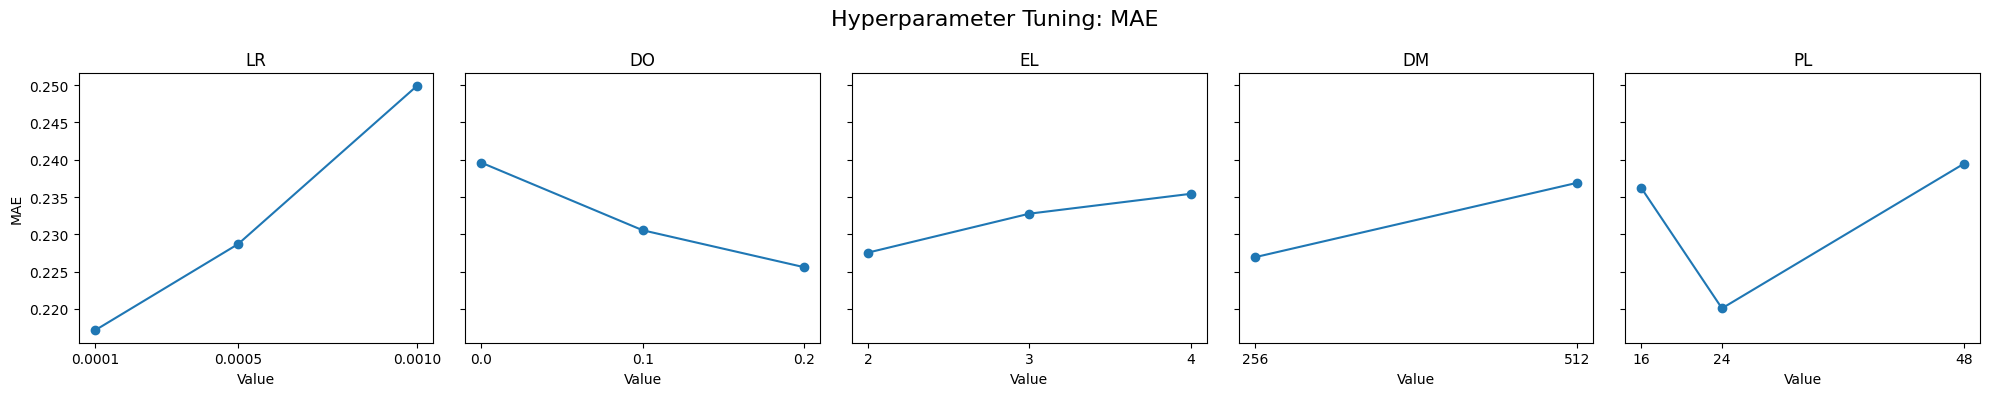

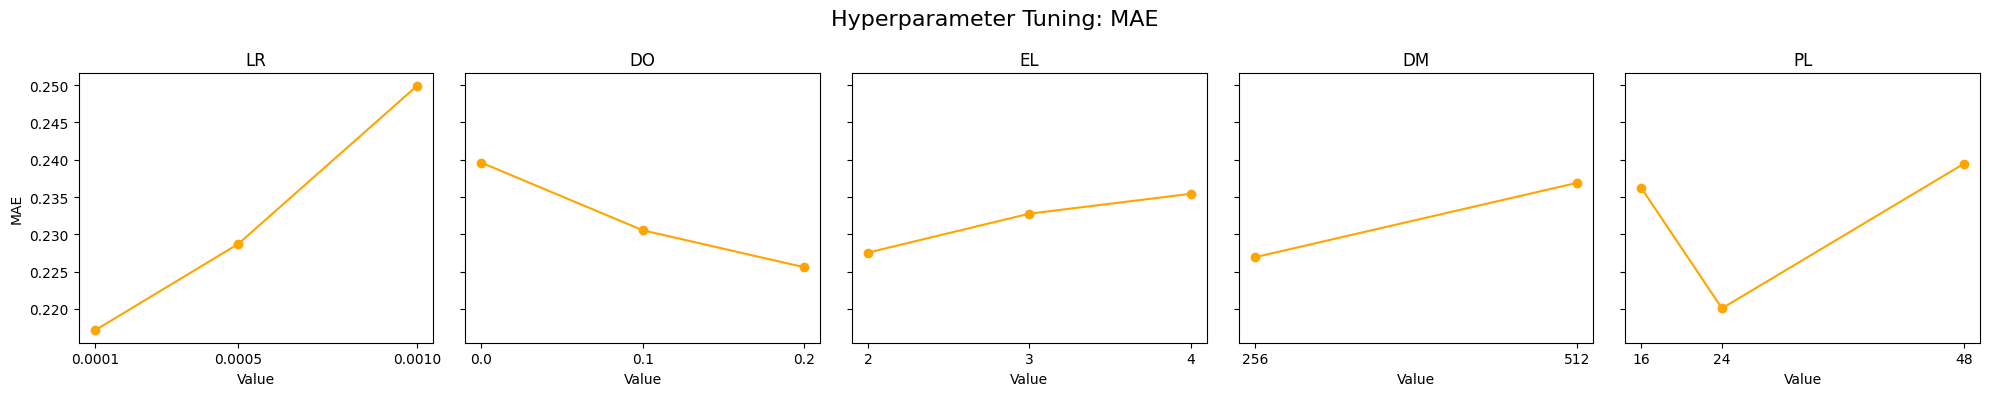

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for ax, param in zip(axes, hyperparams):
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    ax.plot(grouped.index, grouped['mae'], marker='o', color='orange')  # set orange here
    ax.set_title(param)
    ax.set_xticks(param_values[param])
    ax.set_xlabel('Value')

axes[0].set_ylabel('MAE')
fig.suptitle('Hyperparameter Tuning: MAE', fontsize=16)
plt.tight_layout()
plt.show()

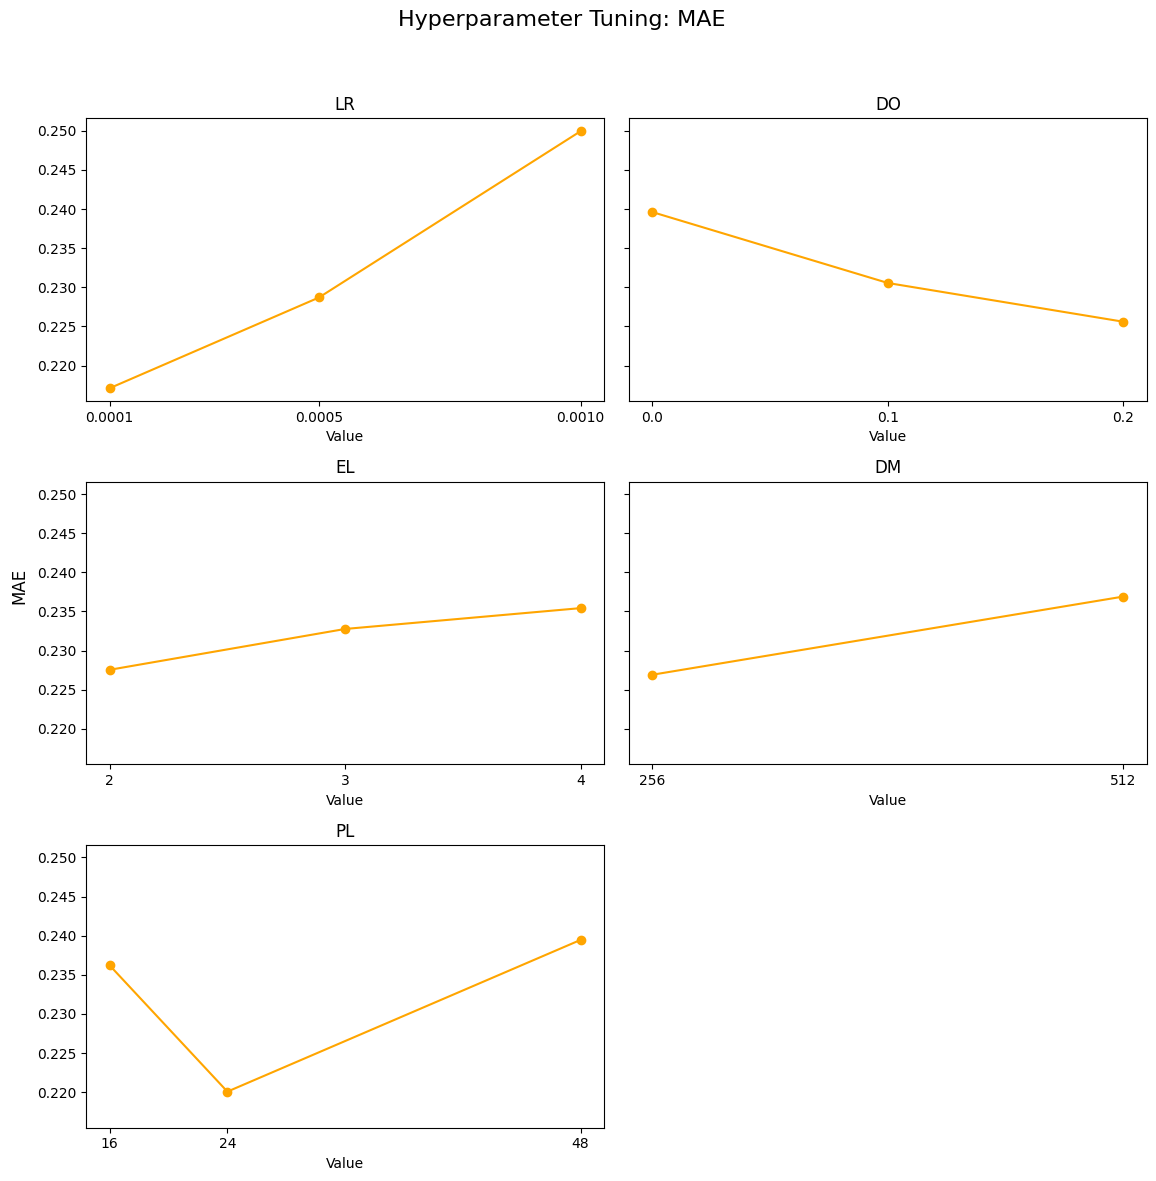

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Plot the first 4 in the first two rows
for i, param in enumerate(hyperparams[:4]):
    ax = axes[i]
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    ax.plot(grouped.index, grouped['mae'], marker='o', color='orange')
    ax.set_title(param)
    ax.set_xticks(param_values[param])
    ax.set_xlabel('Value')

# Plot the last one (centered at bottom)
ax = axes[4]
grouped = df.groupby(hyperparams[4]).mean(numeric_only=True).sort_index()
ax.plot(grouped.index, grouped['mae'], marker='o', color='orange')
ax.set_title(hyperparams[4])
ax.set_xticks(param_values[hyperparams[4]])
ax.set_xlabel('Value')

# Turn off the last empty subplot
axes[5].axis('off')

# Add shared y-label
fig.text(0.04, 0.5, 'MAE', va='center', rotation='vertical', fontsize=12)

fig.suptitle('Hyperparameter Tuning: MAE', fontsize=16)
plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()

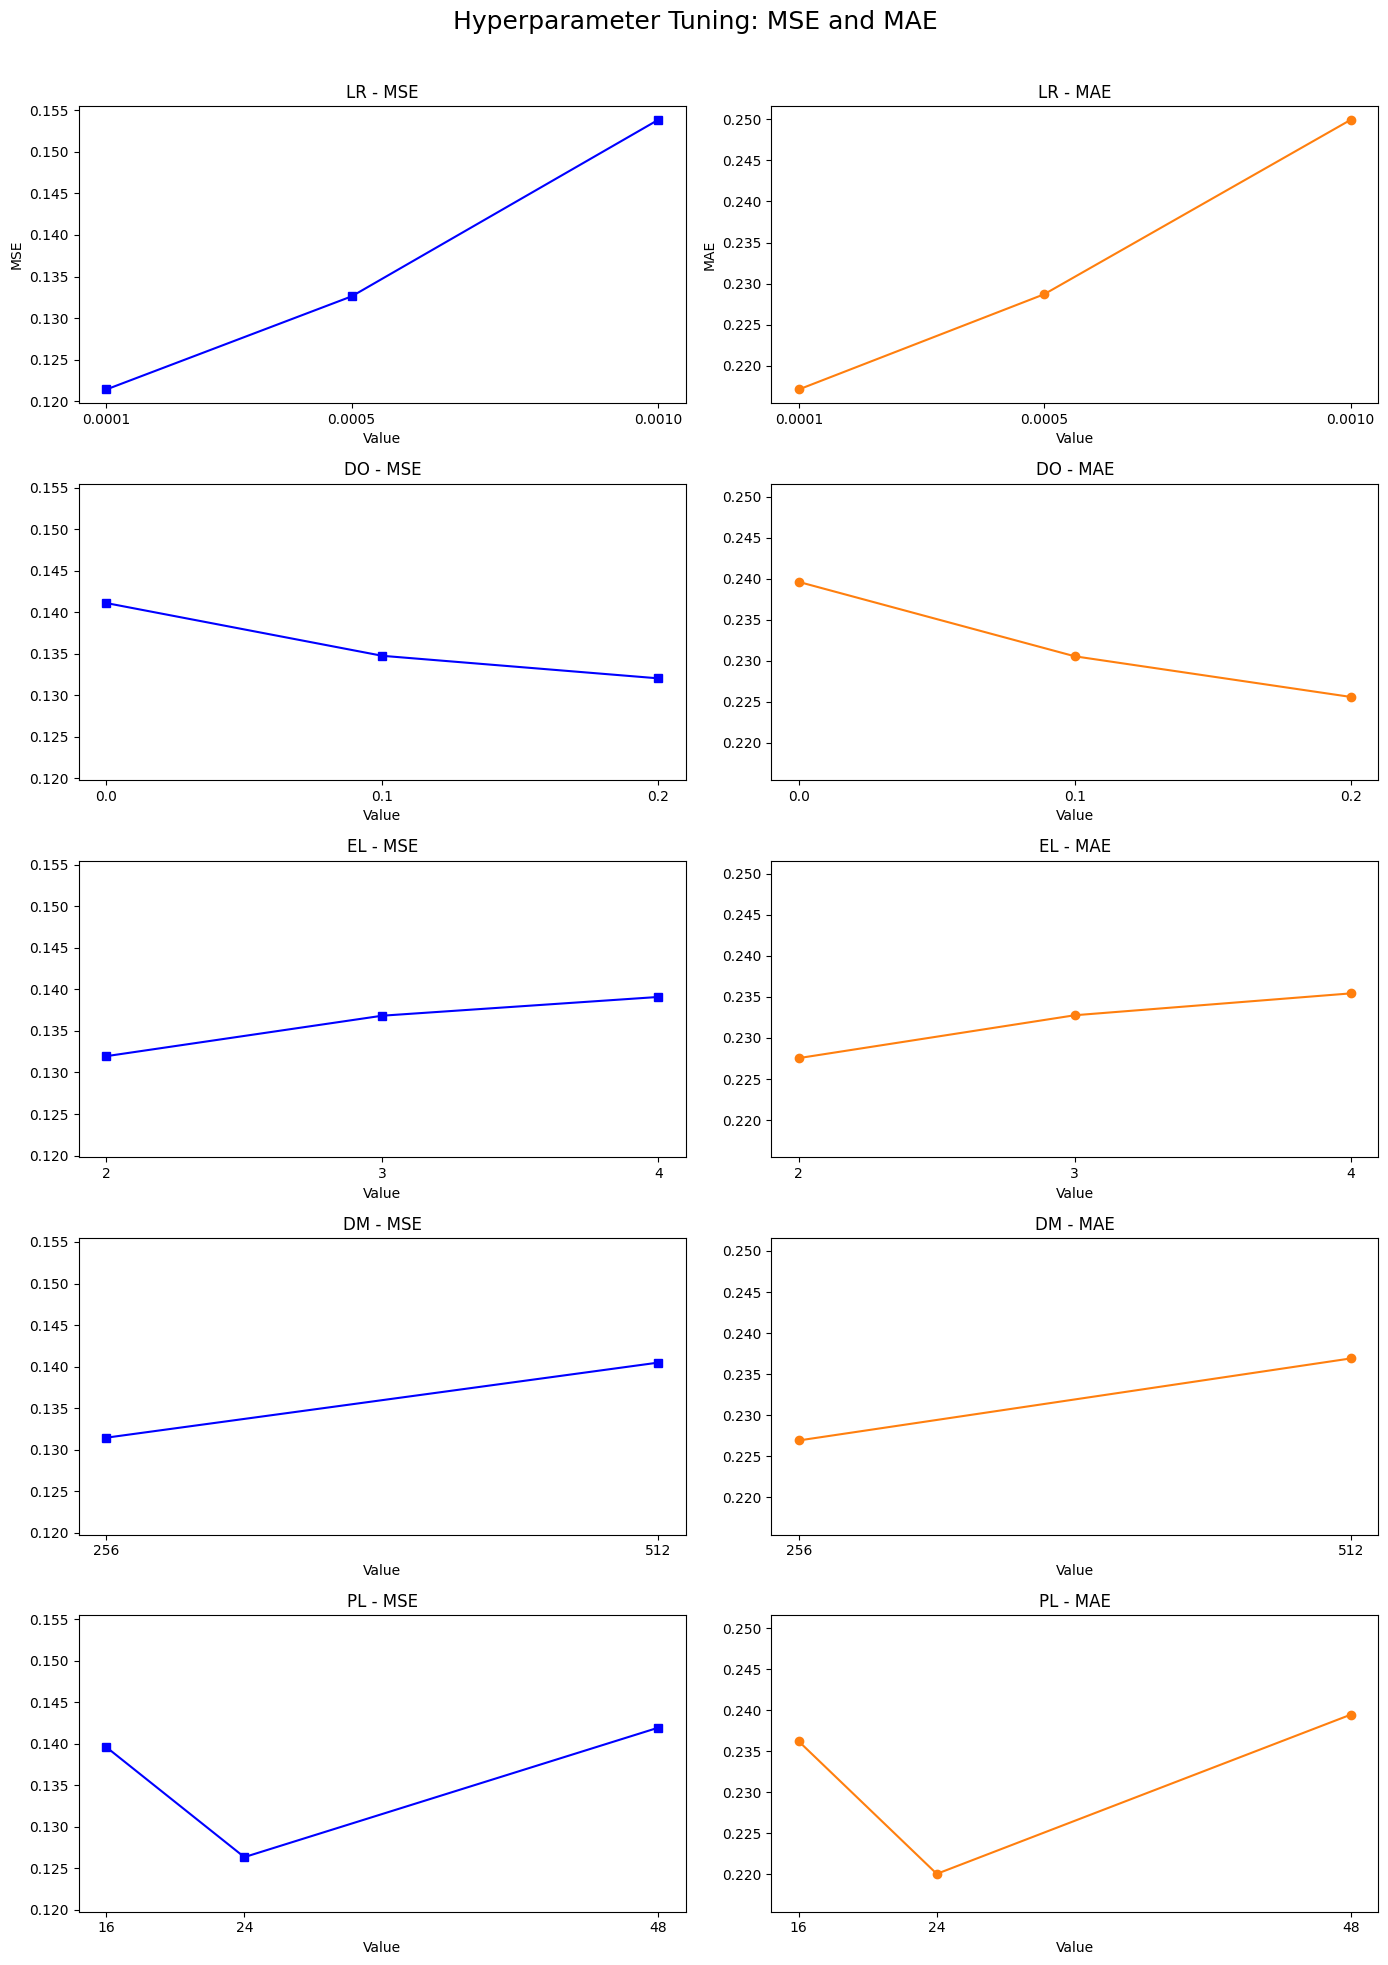

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

fig, axes = plt.subplots(5, 2, figsize=(14, 20), sharey='col')

for row, param in enumerate(hyperparams):
    # MSE on the left (blue)
    ax_mse = axes[row, 0]
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    ax_mse.plot(grouped.index, grouped['mse'], marker='s', color='blue')
    ax_mse.set_title(f'{param} - MSE')
    ax_mse.set_xticks(param_values[param])
    ax_mse.set_xlabel('Value')
    if row == 0:
        ax_mse.set_ylabel('MSE')

    # MAE on the right (improved orange)
    ax_mae = axes[row, 1]
    ax_mae.plot(grouped.index, grouped['mae'], marker='o', color='#FF7F0E')  # better orange
    ax_mae.set_title(f'{param} - MAE')
    ax_mae.set_xticks(param_values[param])
    ax_mae.set_xlabel('Value')
    if row == 0:
        ax_mae.set_ylabel('MAE')

fig.suptitle('Hyperparameter Tuning: MSE and MAE', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save as PNG
fig.savefig('hyperparam_tuning.png', dpi=300, bbox_inches='tight')

plt.show()

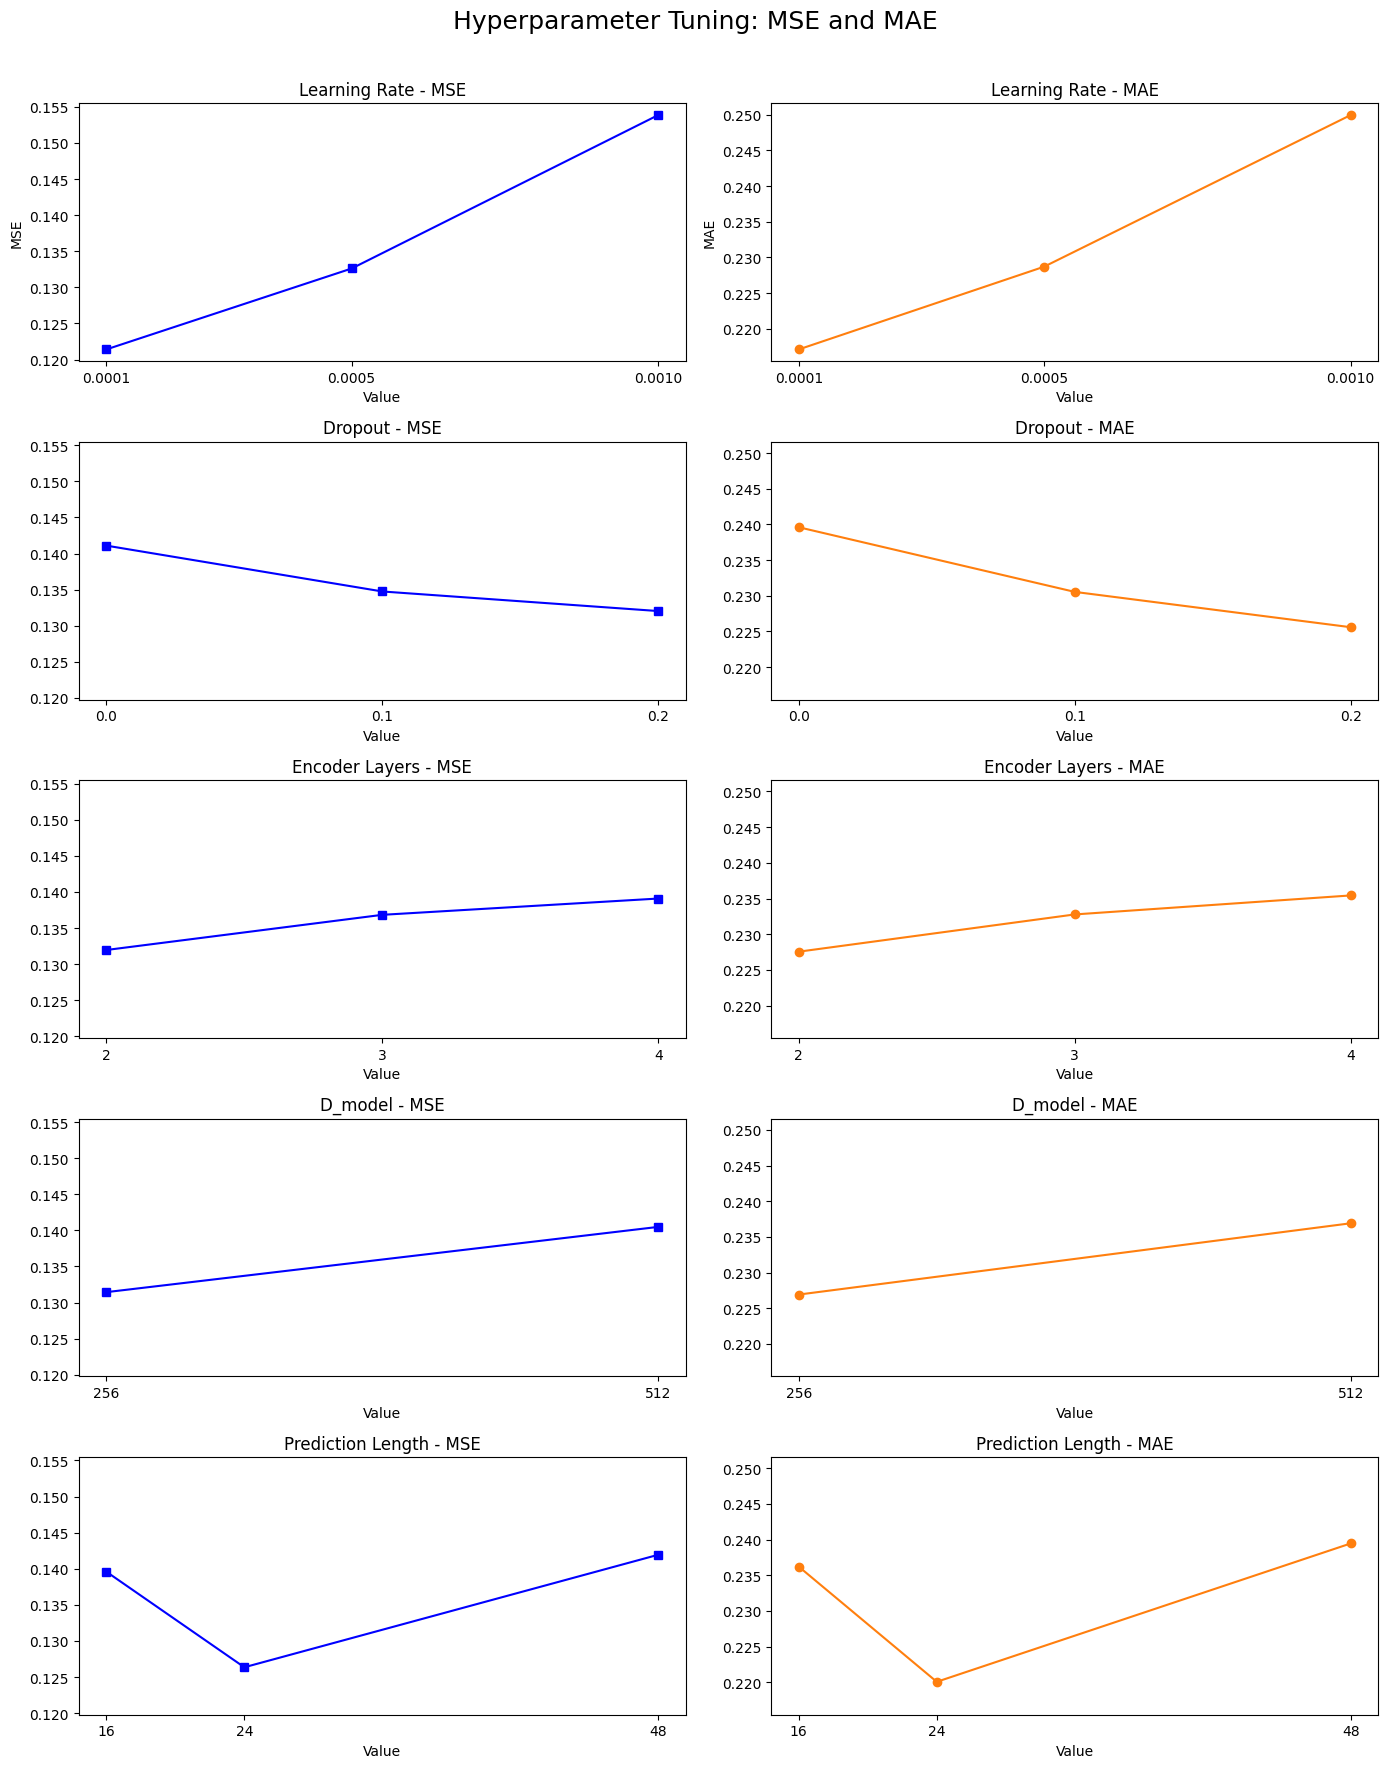

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.ioff()
plt.style.use('default')

# Mapping for better display names
param_display_names = {
    'LR': 'Learning Rate',
    'DO': 'Dropout',
    'EL': 'Encoder Layers',
    'DM': 'D_model',
    'PL': 'Prediction Length'
}

hyperparams = ['LR', 'DO', 'EL', 'DM', 'PL']

param_values = {
    'LR': [1e-3, 5e-4, 1e-4],
    'DO': [0.0, 0.1, 0.2],
    'EL': [2, 3, 4],
    'DM': [256, 512],
    'PL': [16, 24, 48],
}

fig, axes = plt.subplots(5, 2, figsize=(14, 18), sharey='col')

for row, param in enumerate(hyperparams):
    display_name = param_display_names[param]
    
    # MSE on the left (blue)
    ax_mse = axes[row, 0]
    grouped = df.groupby(param).mean(numeric_only=True).sort_index()
    ax_mse.plot(grouped.index, grouped['mse'], marker='s', color='blue')
    ax_mse.set_title(f'{display_name} - MSE')
    ax_mse.set_xticks(param_values[param])
    ax_mse.set_xlabel('Value')
    if row == 0:
        ax_mse.set_ylabel('MSE')

    # MAE on the right (better orange)
    ax_mae = axes[row, 1]
    ax_mae.plot(grouped.index, grouped['mae'], marker='o', color='#FF7F0E')
    ax_mae.set_title(f'{display_name} - MAE')
    ax_mae.set_xticks(param_values[param])
    ax_mae.set_xlabel('Value')
    if row == 0:
        ax_mae.set_ylabel('MAE')

fig.suptitle('Hyperparameter Tuning: MSE and MAE', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save as PNG
fig.savefig('hyperparam_tuning.png', dpi=600, bbox_inches='tight')

plt.show()